# Introduction to HistFactory Models

🎶 I'm the very Model of a simple HEP-like measurement... 🎶

## HEP-like?

So what do we do as experimentalists in High Energy Physics? We have a gigantic detector that serves as a counting machine for physics. We smash particles and take pictures of the aftermath. Then we propose hypotheses for new physics that we want to test using this data. So we will have, at the very least:

* signal
* background (with some uncertainty)
* some observations

This is probably the simplest model one could use in HistFactory... so let's make it.

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil

In [2]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=[5.0, 10.0], bkg=[50.0, 60.0], bkg_uncertainty=[5.0, 12.0]
)
model

What did we just make? This returns a [`pyhf.pdf.Model`](https://pyhf.readthedocs.io/en/v0.6.2/_generated/pyhf.pdf.Model.html#pyhf.pdf.Model) object. Let's check out the specification.

In [3]:
print(json.dumps(model.spec, indent=2))

{
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            5.0,
            10.0
          ],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": null
            }
          ]
        },
        {
          "name": "background",
          "data": [
            50.0,
            60.0
          ],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [
                5.0,
                12.0
              ]
            }
          ]
        }
      ]
    }
  ]
}


As we can see from the specification, we defined a single two-bin channel ('singlechannel') with two samples: a **signal sample** and a **background sample**. The signal sample has an _unconstrained normalization factor_ $\mu$, the signal strength, while the background sample carries an _uncorrelated shape systematic_ controlled by parameters $\gamma_{1}$ and $\gamma_{2}$. The _background uncertainty_ for the bins is $10\%$ and $20\%$ respectively.

These uncertainties are **absolute** (not relative!). We have 10% and 20% relative uncertainty for the bins in the background sample respectively.

(*Note: we have a workspace defined with this simple model in `data/2-bin_1-channel.json` which we will look at later.*)

Let's explore the model a little bit.

In [4]:
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"  nauxdata: {model.config.nauxdata}")
print(f"   auxdata: {model.config.auxdata}")

  channels: ['singlechannel']
     nbins: {'singlechannel': 2}
   samples: ['background', 'signal']
 modifiers: [('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]
parameters: ['mu', 'uncorr_bkguncrt']
  nauxdata: 2
   auxdata: [100.0, 25.0]


## Auxiliary Data

Whoa, hold up! What's with the auxiliary data? Recall the HistFactory definition

$$
p(n,a|\theta) = \underbrace{\prod_{\mathrm{channel}\ c}\prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_{cb} | \lambda_{cb}(\theta))}_{\text{main}} \underbrace{\prod_{\mathrm{constraint}\ \chi} p_\chi(a_\chi | \chi)}_{\text{auxiliary}}
$$

for

$$
\lambda_{cb}(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{cbs}(\theta)
$$

and the auxiliary data here is passed into a constraint function. There's two things going on here:

1. The uncorrelated shapesys modifier is constrained by a Poisson.
2. The auxiliary data is fully determined by the shapesys 'data' and the 'background' data.

So if we were to explicitly write out the likelihood we were seeing symbolically, it would be:

$$
\begin{align}
p_\text{main} \cdot p_\text{aux} &= \text{Pois}(n | \lambda) \cdot p_\text{aux}\\
                                 &= \text{Pois}(n | \mu s + \gamma b) \cdot p_\text{aux}\\
                                 &= \text{Pois}(n | \mu s + \gamma b) \cdot \text{Pois}(n_\text{aux} = (b/\delta b)^2 | \mu = (b/\delta b)^2 \gamma )\\
\end{align}
$$

where $n = \{n_1, n_2\}$ for a 2-bin model (we're being slightly fast and loose with our mathematical notation here), and similarly for $s$, $b$, and $\gamma$.

The 'shapesys' is defined in the [HistFactory paper](https://cds.cern.ch/record/1456844)... however, it can be a little hard to extract out the necessary information. We've provided a nice table of [Modifiers and Constraints](https://pyhf.readthedocs.io/en/v0.6.2/intro.html#id24) in the introduction of our pyhf documentation to use as reference.

![modifiers and constraints](assets/modifiers_and_constraints.png)

Let's look at the first row here which is our uncorrelated shape modifier. This is a multiplicative modifier denoted by $\kappa$ per-bin (denoted by $\gamma_b$). Notice that the input for the constraint term requires $\sigma_b$ which is the relative uncertainty of that modifier. This is Poisson-constrained by $\sigma_b^{-2}$. Let's quickly calculate "by hand" the auxiliary data to convince ourselves of what's going on here (remembering that the background uncertainties were 10% and 20% of the observed background counts):

In [5]:
(np.array([5.0, 12.0]) / np.array([50.0, 60.0])) ** -2

array([100.,  25.])

which is what we see from the `pyhf.pdf.Model` API

In [6]:
model.config.auxdata

[100.0, 25.0]

Everything looks good!

## Data and Parameters

What about the actual data for the model then?

In [7]:
model.expected_data()

TypeError: expected_data() missing 1 required positional argument: 'pars'

Hrmm, that didn't work. It seems we need to specify the parameter values to get the data for the model at those parameter values. Well, we know the default for $\mu=1$ and $\gamma = 1$. Also recall that the uncorrelated shape allocates a parameter per bin, so our model has **3 parameters** with **2 modifiers**. So let's just try that:

In [8]:
model.expected_data([1.0, 1.0,1.0])

array([ 55.,  70., 100.,  25.])

This returns the expected data given the model parameters for the entire likelihood for the 2 bin model, the main model as well as the constraint (or auxiliary) model. We can also drop the auxdata to get the actual data.

In [9]:
model.expected_data([1.0, 1.0, 1.0], include_auxdata=False)

array([55., 70.])

Similarly, there are also methods separately for the actual data and the auxdata, both which take in all the parameters:

In [10]:
model.expected_actualdata([1.0, 1.0, 1.0])

array([55., 70.])

In [11]:
model.expected_auxdata([1.0, 1.0, 1.0])

array([100.,  25.])

### The Parameter Ordering

So how do we know what these parameters correspond to? The way `pyhf` works under the hood, you can imagine an `n`-dimensional tensor that is purely bookkeeping all the different expected rates and modifications (read: systematics) involved that we can apply tensor algebra calculations to. This means that the ordering of the entries in each dimension is important, so we need to keep track of the order of the channels, the samples, the parameters. In `pyhf`, you can ask for the parameters or modifiers in a model:

In [12]:
model.config.parameters

['mu', 'uncorr_bkguncrt']

In [13]:
model.config.modifiers

[('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]

However, these might **not necessarily** correspond with the order of the parameters when we build this tensor internally, and we keep this order under a different variable

In [14]:
model.config.par_order

['mu', 'uncorr_bkguncrt']

### The Parameter Multiplicity

But this clearly doesn't answer everything, because we were using three numbers assigned to two parameters! How does that work? Well, recall that the only channel in this model has 2 bins:

In [15]:
model.config.channel_nbins

{'singlechannel': 2}

and one of the parameters (the uncorrelated shape systematic) will be configured by $\gamma_b$ &mdash; that is, one parameter for each bin of the sample in that channel. How does `pyhf` know that the parameter set is associated with two parameters? We can ask for information about the `paramset`:

In [16]:
model.config.param_set("uncorr_bkguncrt")

which we can see is constrained by a Poisson and

In [17]:
model.config.param_set("uncorr_bkguncrt").n_parameters

2

### The Parameter Defaults

So how do we know what we should set the parameters to? The nice thing is that this is up to you! The model will come with some suggested defaults for parameters...

In [18]:
model.config.suggested_init()

[1.0, 1.0, 1.0]

...and their bounds

In [19]:
model.config.suggested_bounds()

[(0, 10), (1e-10, 10.0), (1e-10, 10.0)]

... and if the parameter should be held constant in a fit or not

In [20]:
model.config.suggested_fixed()

[False, False, False]

So armed with this knowledge, we could have also done

In [21]:
init_pars = model.config.suggested_init()
model.expected_actualdata(init_pars)

array([55., 70.])

To get the expected actual data from the model (signal + background), we could turn off the signal, corresponding with the normalization factor. We just need to know the index of the parameter:

In [22]:
model.config.poi_index

0

and then just change the parameter

In [23]:
bkg_pars = init_pars.copy()
bkg_pars[model.config.poi_index] = 0
model.expected_actualdata(bkg_pars)

array([50., 60.])

## Simple Inference

The core of statistical analysis is the statistical model. For inference, it's viewed as a function of the model parameters conditioned on the fixed observations.

$$
\log L(\theta | x) \propto \log p(x | \theta)
$$

The value of the likelihood is a float. Let's try it for both the background-only model as well as the signal+background model.

In [24]:
observations = [55.0, 70.0] + model.config.auxdata  # this is a common pattern!
#observations = [80.0, 130.0] + model.config.auxdata  # this is a common pattern!
#observations = [100.0, 160.0] + model.config.auxdata  # this is a common pattern!

model.logpdf(pars=bkg_pars, data=observations)

array([-12.75517092])

In [25]:
model.logpdf(pars=init_pars, data=observations)

array([-11.72256344])

We're not performing inference just yet. We're simply computing the 'logpdf' of the model specified by the parameters $\theta$ against the provided data. To perform a fit, we use the [inference API](https://pyhf.readthedocs.io/en/v0.6.2/api.html#inference) via `pyhf.infer`.

When fitting a model to data, we usually want to find the $\hat{\theta}$ which refers to the "Maximum Likelihood Estimate" of the model parameters. This is often referred to mathematically by

$$
\hat{\theta}_\text{MLE} = \text{argmax}_\theta L(\theta | x)
$$

Let's perform a unconstrained maximum likelihood fit on this model to the provided observations we just made up.

In [26]:
pyhf.infer.mle.fit(data=observations, pdf=model)

array([1., 1., 1.])

So what can we say? With nominal signal `[5, 10]` and nominal background = `[50, 60]` model components, an observed count of `[53, 65]` suggests best fit values:
* $\hat{\mu} \approx 0.54$,
* $\hat{\gamma} \approx [1,1]$.

## Simple Hypothesis Testing

Great, so we can fit. But that's not usually the interesting part, since we cannot make any statements about this. What we prefer to do is perform a hypothesis test to either:

* Reject Standard Model hypothesis &mdash; a discovery fit.
* Reject Beyond the Standard Model hypothesis &mdash; an exclusion fit.

So we need to compute test statistics in order to evaluate the hypothesis. If we know the distribution of the test statistic under two different hypotheses, we can compute a [CLs](https://en.wikipedia.org/wiki/CLs_method_(particle_physics)) value. This is a modified pseudo-frequentist $p\,$-value.

$$
\text{CL}_\text{s} = \frac{\text{CL}_\text{s+b}}{\text{CL}_\text{b}} = \frac{p_{\text{s+b}}}{1-p_{\text{b}}}
$$

with

$$
\text{CL}_\text{s+b} = \int_{t_\text{obs}}^\infty \text{d}t\ p_0(t | H_0) \qquad\qquad \text{CL}_\text{b} = \int_{t_\text{obs}}^\infty \text{d}t\ p_1(t | H_1)
$$

This is done by splitting the model parameters up into two groups:

* parameters of interest (POI &mdash; can have multiple!)
* nuisance parameters (NP)

Recall that additionally, all parameters are either constrained or unconstrained. Parameters of interest happen to always be unconstrained parameters.

$$
    f(\boldsymbol{x}|\phi) = f(\boldsymbol{x}|\overbrace{\eta}^{\llap{\text{free}}},\underbrace{\chi}_{\llap{\text{constrained}}}) = f(\boldsymbol{x}|\overbrace{\psi}^{\rlap{\text{parameters of interest}}},\underbrace{\theta}_{\rlap{\text{nuisance parameters}}})
$$

In the vast majority of cases, the test statistic is the profile likelihood ratio, or variations of it:

$$
t_\psi(x) = \frac{L(\psi, \hat{\hat{\theta}})}{L({\hat{\psi}, \hat{\theta}})}
$$

where

* $\hat{\hat{\theta}}$ is the best fitted value of the nuisance parameters (for fixed POIs)
* $\hat{\psi}$ and $\hat{\theta}$ are the best fitted values in a global fit

So let's run a limit setting (exclusion) hypothesis test for

* null hypothesis ($\mu = 1$) &mdash; "BSM physics process exists"
* alternate hypothesis ($\mu = 0$) &mdash; "Standard Model only physics"

In [27]:
CLs_obs, CLs_exp = pyhf.infer.hypotest(
    1.0,  # null hypothesis
    [55.0, 70.0] + model.config.auxdata,
    model,
    test_stat="q",
    return_expected_set=True,
)
print(f"      Observed CLs: {CLs_obs:.4f}")
for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

qmu test statistic used for fit configuration with POI bounded at zero.
Use the qmu_tilde test statistic (pyhf.infer.test_statistics.qmu_tilde) instead.
qmu test statistic used for fit configuration with POI bounded at zero.
Use the qmu_tilde test statistic (pyhf.infer.test_statistics.qmu_tilde) instead.


      Observed CLs: 0.6172
Expected CLs(-2 σ): 0.0878
Expected CLs(-1 σ): 0.1901
Expected CLs( 0 σ): 0.3797
Expected CLs( 1 σ): 0.6518
Expected CLs( 2 σ): 0.8892


Nicely enough, `pyhf` is smart enough to let us know that, if for a model where $\hat{\psi} < 0$, we're not going to be able to catch it because our default bounds were bounding the parameter of interest from below at 0. For more information, see Equation 14 in [[1007.1727]](https://arxiv.org/abs/1007.1727).

In [28]:
model.config.suggested_bounds()[model.config.poi_index]

(0, 10)

We should heed the warning and switch our test statistic in this case to a variation of it $q_\mu \to \tilde{q}_\mu$. We could also change the bounds from the default to allow $\mu$ to float below zero. In this case, we're just going to use a more appropriate test statistic as we know $\hat{\mu} \geq 0$.

In [29]:
CLs_obs, CLs_exp = pyhf.infer.hypotest(
    1.0,  # null hypothesis
#    [53.0, 65.0] + model.config.auxdata,
    [80.0, 130.0] + model.config.auxdata,
    model,
    test_stat="qtilde",
    return_expected_set=True,
)
print(f"      Observed CLs: {CLs_obs:.4f}")
for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

      Observed CLs: 0.6490
Expected CLs(-2 σ): 0.1349
Expected CLs(-1 σ): 0.2578
Expected CLs( 0 σ): 0.4591
Expected CLs( 1 σ): 0.7161
Expected CLs( 2 σ): 0.9170


## Simple Upper Limit

To get upper limits, we just need to run multiple hypothesis tests for a lot of different null hypotheses of BSM with $\mu \in [0, \ldots, 5.0]$ and then find the value of $\mu$ for which the null hypothesis is rejected (a 95% $\text{CL}_\text{s}$). We can do all of this very easily just using the [`upperlimit` API](https://pyhf.readthedocs.io/en/v0.6.2/_generated/pyhf.infer.intervals.upperlimit.html), which also can calculate the upper limit by interpolating

In [30]:
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upperlimit(
    observations, model, poi_values, level=0.05, return_results=True
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

Upper limit (obs): μ = 2.9537
Upper limit (exp): μ = 2.2165


We can plot the standard "Brazil band" of the observed and expected $\text{CL}_\text{s}$ values using the `pyhf.contrib` module (which needs `pyhf[contrib]`):

The horiztonal red line indicates the test size ($\alpha=0.05$), whose intersection with the $\text{CL}_\text{s}$ lines visually represents the $(1-\alpha)\%$ CL limit on the POI.

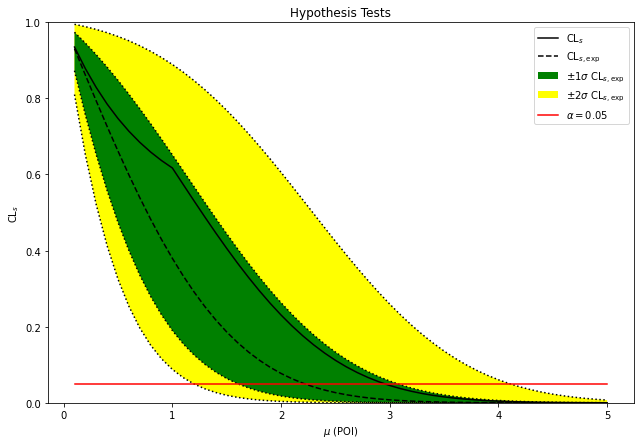

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7)
ax.set_title("Hypothesis Tests")

artists = brazil.plot_results(poi_values, results, ax=ax)

Note that if you wanted to do all of this "by hand" you still could pretty easily. The `pyhf.infer.intervals.upperlimit` API just makes it easier.

In [32]:
# Perform a hypothesis test scan across POIs
results = [
    pyhf.infer.hypotest(
        poi_value,
        observations,
        model,
        test_stat="qtilde",
        return_expected_set=True,
    )
    for poi_value in poi_values
]

# Calculate upper limit through interpolation
observed = np.asarray([h[0] for h in results]).ravel()
expected = np.asarray([h[1][2] for h in results]).ravel()
print(f"Upper limit (obs): μ = {np.interp(0.05, observed[::-1], poi_values[::-1]):.4f}")
print(f"Upper limit (exp): μ = {np.interp(0.05, expected[::-1], poi_values[::-1]):.4f}")

Upper limit (obs): μ = 2.9537
Upper limit (exp): μ = 2.2165
